# Inicialización

## Importar librerías

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dropout, BatchNormalization, ReLU,concatenate, Layer, Input
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
!python --version
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Python 3.9.12
Num GPUs Available:  1


## Importar data

In [3]:
files = [f for f in os.listdir('lsp_dataset/images') if os.path.isfile(os.path.join('lsp_dataset/images', f))]
print('Inputs: ')
len(files)

Inputs: 


2000

First:
[[ 29.74645941 143.34544031   0.        ]
 [ 30.5501068  117.22690013   0.        ]
 [ 28.94281202  84.67918082   0.        ]
 [ 43.00664135  85.08100452   0.        ]
 [ 42.20299396 111.1995447    0.        ]
 [ 42.60481765 132.89802424   0.        ]
 [ 24.52275137  52.9351089    0.        ]
 [ 15.28080638  62.98070128   0.        ]
 [ 24.12092767  42.08586913   0.        ]
 [ 50.64129155  44.09498761   0.        ]
 [ 52.65041003  58.96246433   0.        ]
 [ 53.85588112  58.96246433   0.        ]
 [ 38.184757    36.05851371   0.        ]
 [ 38.9884044   15.56550525   0.        ]]


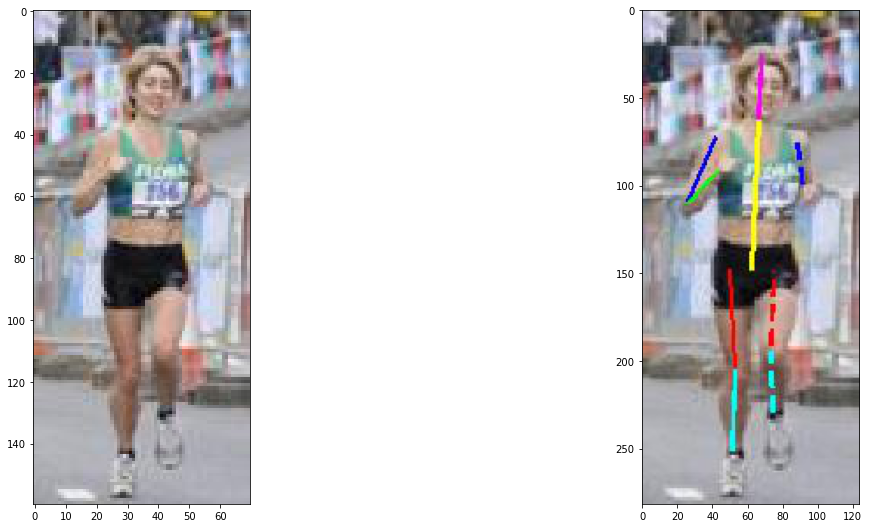

In [4]:
jointsFile = scipy.io.loadmat('lsp_dataset/joints.mat')['joints']
joints = np.empty((2000,14,3))

#Reestructuración de articulaciones pues el dataset las tiene almacenadas de manera diferente
for i in range(3):
    for j in range(14):
        for k in range(2000):
            joints[k][j][i] = jointsFile[i][j][k]

print('First:')
print(joints[0])
plt.figure(figsize=(20,20))
ax = plt.subplot(2,2,1)
image = mpimg.imread('lsp_dataset/images/im0001.jpg')
plt.imshow(image)
ax = plt.subplot(2,2,2)
image = mpimg.imread('lsp_dataset/visualized/im0001.jpg')
plt.imshow(image)

## Variables globales

In [5]:
W = 160 #Ancho de las imagenes estandarizadas
H = 160 #Alto de las imagenes estandarizadas
nArt = 14 #Nro de articulaciones

## PRE PROCESAMIENTO

In [6]:
#Funcion para resize que conserve el aspect ratio original y coloque fondo negro
def resize_img(img,size=(256,256)):
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

(8000, 160, 160, 3)
(8000, 14, 2)
(8000, 14)
[[0.46716537 0.895909  ]
 [0.47218817 0.73266813]
 [0.46214258 0.52924488]
 [0.55004151 0.53175628]
 [0.54501871 0.69499715]
 [0.54753011 0.83061265]
 [0.4345172  0.33084443]
 [0.37675504 0.39362938]
 [0.4320058  0.26303668]
 [0.59775807 0.27559367]
 [0.61031506 0.3685154 ]
 [0.61784926 0.3685154 ]
 [0.51990473 0.22536571]
 [0.52492753 0.09728441]]


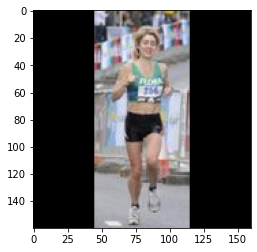

In [7]:
res_imgs = []
art_porcs = []
art_vis = []
cols = ['File']

for i in range(1,15):
    cols.append('JX'+str(i))
    cols.append('JY'+str(i))
    cols.append('JB'+str(i))

#Dataframe donde se guarda toda la información del dataset correctamente formateado
data = pd.DataFrame(columns=cols)

for i in range(2000):
    arts = []
    arts_vi = []
    path = 'lsp_dataset/images/' +'im'+str(i+1).zfill(4)+  '.jpg'
    dict = {'File': path}
    img = cv2.imread(path)
    
    #dimensiones originales de las imagenes
    h, w = img.shape[:2]
    
    #dif: dimensión más grande de la imagen (ancho o alto)
    dif = h if h > w else w
    #difw: diferencia entre la dimensión más grande y el ancho
    difw = (dif - w)//2
    #difh: diferencia entre la dimensión más grande y el alto
    difh = (dif - h)//2
    res = resize_img(img,(H, W))
    
    #Imagen original
    for j in range(nArt):
        #Reposicionamiento de las articulaciones en la imagen redimensionada y con las nuevas dimensiones
        jx = (joints[i][j][0]+difw)/dif
        jy = (joints[i][j][1]+difh)/dif
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res_imgs.append(res)
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    dict = {'File': path}
    #Imagen flip-horizontal
    for j in range(nArt):
        #Reposicionamiento de las articulaciones en la imagen invertida, redimensionada, y con las nuevas dimensiones
        jx = 1 - ((joints[i][j][0]+difw)/dif)
        jy = (joints[i][j][1]+difh)/dif
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res_imgs.append(cv2.flip(res,1))
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    dict = {'File': path}
    #Imagen flip-vertical
    for j in range(nArt):
        #Reposicionamiento de las articulaciones en la imagen invertida, redimensionada, y con las nuevas dimensiones
        jx = (joints[i][j][0]+difw)/dif
        jy = 1-((joints[i][j][1]+difh)/dif)
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res_imgs.append(cv2.flip(res,0))
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
    arts = []
    arts_vi = []
    dict = {'File': path}
    #Imagen flip-diagonal
    for j in range(nArt):
        #Reposicionamiento de las articulaciones en la imagen invertida, redimensionada, y con las nuevas dimensiones
        jx = 1 - ((joints[i][j][0]+difw)/dif)
        jy = 1 - ((joints[i][j][1]+difh)/dif)
        jb = int(joints[i][j][2])
        dict['JX'+str(j+1)] = [jx]
        dict['JY'+str(j+1)] = [jy]
        dict['JB'+str(j+1)] = [jb]
        dict['DA'] = 0
        arts.append(np.asarray([jx,jy]))
        arts_vi.append(jb)
    res_imgs.append(cv2.flip(cv2.flip(res,0),1))
    art_porcs.append(np.asarray(arts))
    art_vis.append(np.asarray(arts_vi))
    df = pd.DataFrame(dict)
    data = pd.concat([data, df], ignore_index=True, axis=0)
    
res_imgs = np.asarray(res_imgs)
art_porcs = np.asarray(art_porcs)
art_vis = np.asarray(art_vis)

print(res_imgs.shape)
print(art_porcs.shape)
print(art_vis.shape)
plt.imshow(cv2.cvtColor(res_imgs[0], cv2.COLOR_BGR2RGB))
print(art_porcs[0])

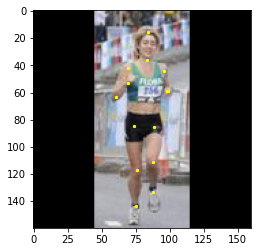

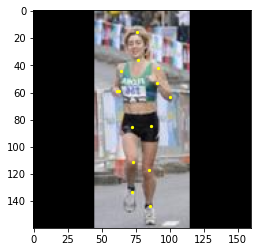

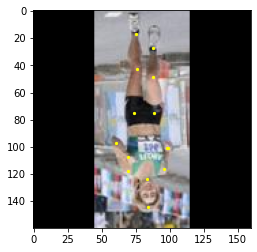

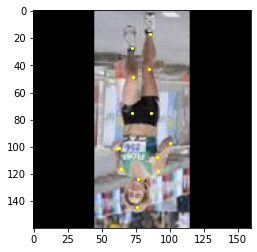

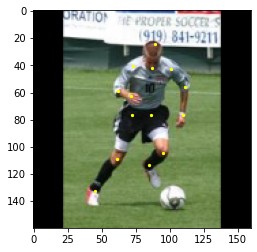

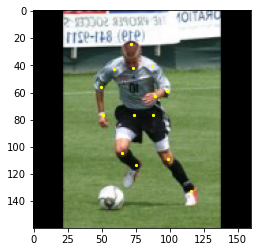

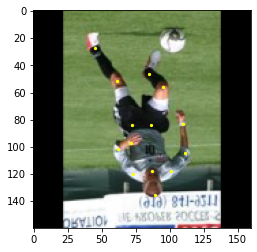

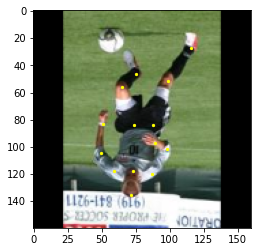

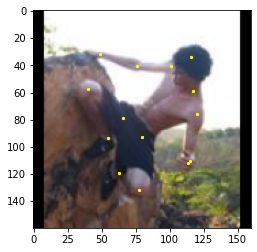

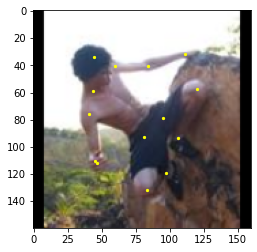

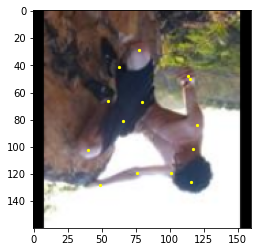

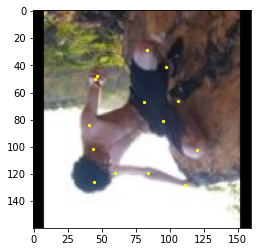

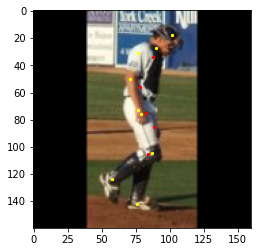

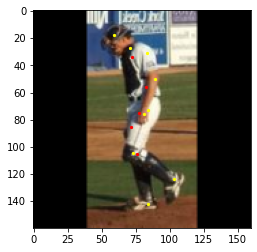

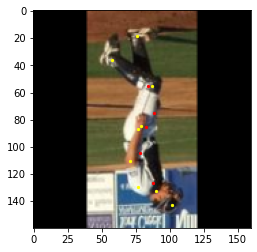

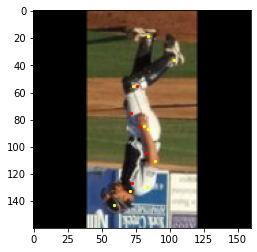

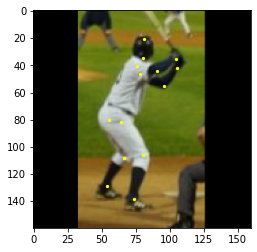

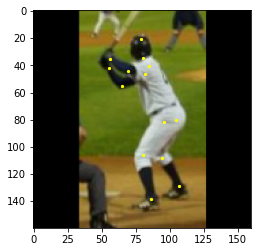

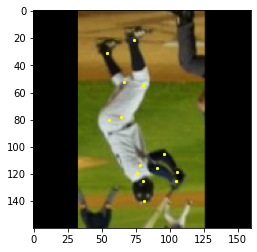

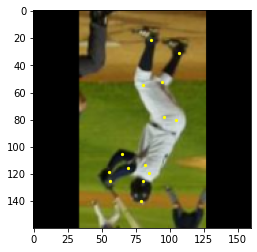

In [8]:
#Verificación del pre-procesamiento
for j in range(20):
    image = res_imgs[j]
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    alt,anc,_ = image.shape
    for i in range(1,nArt+1):
        if not data[f'JB{i}'][j]:
            plt.scatter(data[f'JX{i}'][j]*anc,data[f'JY{i}'][j]*alt, marker=".", color="yellow", s=20)
        else:
            plt.scatter(data[f'JX{i}'][j]*anc,data[f'JY{i}'][j]*alt, marker=".", color="red", s=20)
    plt.show()

In [9]:
X = res_imgs
Y1 = art_porcs
Y2 = art_vis

In [10]:
#Split de la data en train y test
x_train, x_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X,Y1,Y2, test_size=0.15, random_state=100)

## MODELO

In [11]:
def create_model_V3(shape, nArticulaciones=14):
    BN_MOMENTUM = 0.1
    strides = 1
    losses = {}
    input_layer = Input(shape=shape)
      
    bottomLayer = tf.keras.applications.Xception(include_top=False)(input_layer)
    
    bottomLayer.trainable = False

    flatten_1 = tf.keras.layers.Flatten()(bottomLayer)
    
    outputs = []
    for i in range(nArticulaciones):
        dense_12 = Dense(64,activation='relu')(flatten_1)
        dense_13 = Dense(32,activation='relu')(dense_12)
        outputs.append(Dense(2, activation="sigmoid", name=f"nodo_{i}1")(dense_13))
        outputs.append(Dense(1, activation="sigmoid", name=f"nodo_{i}2")(dense_13))
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    return model

In [12]:
epochs = 30
lr = 0.0001

losses = {}
metrics = {}
y_train = {}
y_test = {}
for i in range(nArt):
    losses[f"nodo_{i}1"] = "mean_squared_error"
    losses[f"nodo_{i}2"] = "BinaryCrossentropy"
    metrics[f"nodo_{i}1"] = "mse"
    metrics[f"nodo_{i}2"] = "accuracy"
    y_train[f"nodo_{i}1"] = y1_train[:,i,:]
    y_train[f"nodo_{i}2"] = y2_train[:,i]
    y_test[f"nodo_{i}1"] = y1_test[:,i,:]
    y_test[f"nodo_{i}2"] = y2_test[:,i]

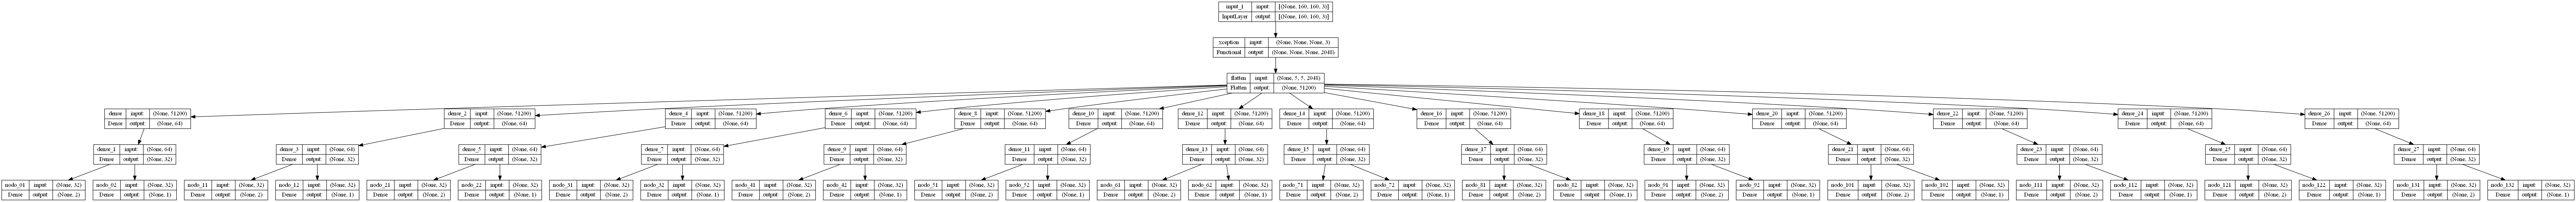

In [13]:
model2 = create_model_V3((W,H,3),nArt)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=losses,metrics=metrics)

plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, None, None,   20861480    ['input_1[0][0]']                
                                2048)                                                             
                                                                                                  
 flatten (Flatten)              (None, 51200)        0           ['xception[0][0]']               
                                                                                              

 nodo_41 (Dense)                (None, 2)            66          ['dense_9[0][0]']                
                                                                                                  
 nodo_42 (Dense)                (None, 1)            33          ['dense_9[0][0]']                
                                                                                                  
 nodo_51 (Dense)                (None, 2)            66          ['dense_11[0][0]']               
                                                                                                  
 nodo_52 (Dense)                (None, 1)            33          ['dense_11[0][0]']               
                                                                                                  
 nodo_61 (Dense)                (None, 2)            66          ['dense_13[0][0]']               
                                                                                                  
 nodo_62 (

In [15]:
X.shape

(8000, 160, 160, 3)

In [16]:
Y1.shape, Y2.shape

((8000, 14, 2), (8000, 14))

In [ ]:
history = model2.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
213/213 [==============================] - 97s 380ms/step - loss: 3.4485 - nodo_01_loss: 0.0391 - nodo_02_loss: 0.1161 - nodo_11_loss: 0.0158 - nodo_12_loss: 0.1181 - nodo_21_loss: 0.0079 - nodo_22_loss: 0.1648 - nodo_31_loss: 0.0060 - nodo_32_loss: 0.2272 - nodo_41_loss: 0.0139 - nodo_42_loss: 0.1536 - nodo_51_loss: 0.0385 - nodo_52_loss: 0.1612 - nodo_61_loss: 0.0246 - nodo_62_loss: 0.3601 - nodo_71_loss: 0.0171 - nodo_72_loss: 0.3013 - nodo_81_loss: 0.0184 - nodo_82_loss: 0.3103 - nodo_91_loss: 0.0216 - nodo_92_loss: 0.3967 - nodo_101_loss: 0.0161 - nodo_102_loss: 0.3782 - nodo_111_loss: 0.0232 - nodo_112_loss: 0.3927 - nodo_121_loss: 0.0209 - nodo_122_loss: 0.0452 - nodo_131_loss: 0.0307 - nodo_132_loss: 0.0294 - nodo_01_mse: 0.0391 - nodo_02_accuracy: 0.9726 - nodo_11_mse: 0.0158 - nodo_12_accuracy: 0.9684 - nodo_21_mse: 0.0079 - nodo_22_accuracy: 0.9531 - nodo_31_mse: 0.0060 - nodo_32_accuracy: 0.9268 - nodo_41_mse: 0.0139 - nodo_42_accuracy: 0.9618 - nodo_51_mse: 0.03

# Resultados

In [ ]:
import plotly.express  as px
histDF = pd.DataFrame(history.history)
px.line(histDF)

In [ ]:
img2 = resize_img(cv2.imread('lsp_dataset/images/im0001.jpg'),(H, W))
#img2 = resize_img(cv2.imread('deportista1.jpg'),(H, W))

points = model2.predict(np.array([img2]))
points

In [ ]:
alt,anc,_ = img2.shape


for i in range(nArt):
    if points[(i*2)+1][0]<0.5:
        plt.scatter(points[i*2][0][0]*anc,points[i*2][0][1]*alt, marker="X", color="yellow", s=30)
    else:
        plt.scatter(points[i*2][0][0]*anc,points[i*2][0][1]*alt, marker="X", color="red", s=30)

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), interpolation='nearest', aspect='auto')   